# Project 02: Exploring Orbital Stability in a Three-Body Coulomb System
**Name:** Arnavdeep Singh

**Introduction:**
This project models a simplified atomic system with two fixed protons and one orbiting electron under classical Coulomb forces. By numerically solving the electron’s equations of motion with `solve_ivp`, we investigate how different initial distances and velocities affect whether the electron forms a bounded orbit or escapes the system. Instead of running simulations for long time periods, orbital stability is determined using energy-based criteria: a bound orbit requires the total mechanical energy to remain negative and approximately conserved. A stability heatmap is produced to map out regions of stable versus unstable motion in the initial condition space.


### Code setup:
    - Importing Libraries
    - Defining constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
k_e = 8.9875517923e9
e = 1.602176634e-19
m_e = 9.1093837015e-31

# two fixed protons
d = 1.0e-10
proton1 = np.array([-d/2, 0.0])
proton2 = np.array([ d/2, 0.0])


T_guess = 1e-16
max_step = T_guess/200
t_span = (0.0, 10*T_guess)

# Safety parameters
r_collision = 1e-12      # collision distance (m)
energy_tol = 1e-3        # relative energy drift tolerance for stability
escape_r_cutoff = 10.0 * d 


### Function for differetial equations

In [4]:
def diff_eqns(t, state):
    x, y, vx, vy = state
    r_vec1 = np.array([x, y]) - proton1
    r_vec2 = np.array([x, y]) - proton2
    r1 = np.linalg.norm(r_vec1)
    r2 = np.linalg.norm(r_vec2)
    ax = -(k_e * e**2 / m_e) * (r_vec1[0]/r1**3 + r_vec2[0]/r2**3)
    ay = -(k_e * e**2 / m_e) * (r_vec1[1]/r1**3 + r_vec2[1]/r2**3)
    return (vx, vy, ax, ay)

### Function for getting total energy

In [5]:
def total_energy_from_state(state):
    x, y, vx, vy = state
    KE = 0.5 * m_e * (vx**2 + vy**2)
    r1 = np.hypot(x - proton1[0], y - proton1[1])
    r2 = np.hypot(x - proton2[0], y - proton2[1])
    PE = -k_e * e**2 / r1 - k_e * e**2 / r2
    return KE + PE

### Function for creating escape event

In [6]:
def make_escape_event():
    def escape_event(t, state):
        return total_energy_from_state(state)
    escape_event.terminal = True
    escape_event.direction = 1.0
    return escape_event

### Function for creating collsion event

In [7]:
def make_collision_event(r_coll=r_collision):
    def collision_event(t, state):
        x, y, vx, vy = state
        d1 = np.hypot(x - proton1[0], y - proton1[1]) - r_coll
        d2 = np.hypot(x - proton2[0], y - proton2[1]) - r_coll
        # return the smaller margin to indicate collision when it crosses zero
        return min(d1, d2)
    collision_event.terminal = True
    collision_event.direction = -1.0
    return collision_event

### Function for creating escape of orbit event

In [8]:
def make_geo_escape_event(cutoff=escape_r_cutoff):
    def geo_escape_event(t, state):
        x, y, vx, vy = state
        r = np.hypot(x, y)
        return r - cutoff
    geo_escape_event.terminal = True
    geo_escape_event.direction = 1.0
    return geo_escape_event

### Run a single orbit, using energy-based early stopping and energy-drift stability test

In [36]:
def run_orbit_energy_based(r0, v0):
    state0 = (0.0, r0, v0, 0.0)
    E0 = total_energy_from_state(state0)

    events = [make_escape_event(), make_collision_event(), make_geo_escape_event()]
    sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-9, atol=1e-9,
                    max_step=max_step, events=events)

    # Determine why integration ended
    reason = "t_span_complete"
    if sol.status == 1:  # event triggered, terminal event
        # check which event triggered
        if sol.t_events[0].size > 0:
            reason = "energy_escape"    # E crossed zero
        elif sol.t_events[1].size > 0:
            reason = "collision"
        elif sol.t_events[2].size > 0:
            reason = "geo_escape"
        else:
            reason = "event_other"
    elif sol.status == 0:
        reason = "t_span_complete"
    else:
        reason = "failed"

    # If we stopped -> unstable
    if reason in ("energy_escape", "geo_escape", "collision"):
        stable = False
        return sol, stable, reason, E0

    # Otherwise evaluate energy drift.
    E_final = total_energy_from_state(sol.y[:, -1])
    rel_drift = abs(E_final - E0) / abs(E0) if abs(E0) > 0 else np.inf

    if rel_drift < energy_tol:
        stable = True
        reason = "stable_energy_conserved"
    else:
        stable = False
        reason = f"energy_drift_{rel_drift:.2e}"

    return sol, stable, reason, E0

### Parameters to sweep over

In [32]:
r0_vals = np.linspace(0.3e-10, 6.0e-10, 40)
v0_vals = np.linspace(0.5e6, 6.0e6, 40)

### Plotting

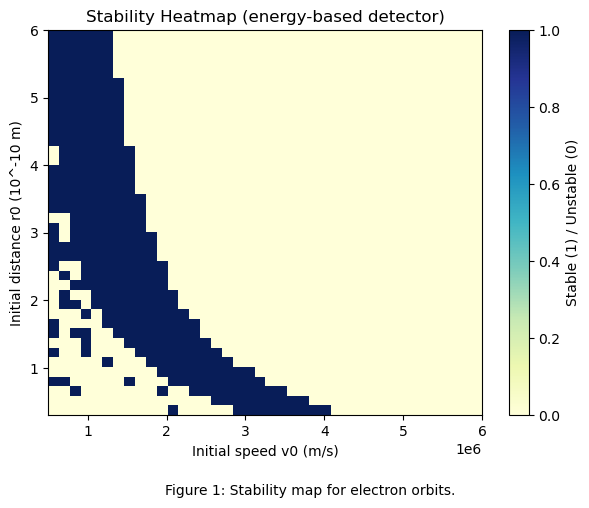

In [33]:
stability_matrix = np.zeros((len(r0_vals), len(v0_vals)))  # 1 stable, 0 unstable
reason_matrix = np.empty((len(r0_vals), len(v0_vals)), dtype=object)

for i, r0 in enumerate(r0_vals):
    for j, v0 in enumerate(v0_vals):
        sol, stable, reason, E0 = run_orbit_energy_based(r0, v0)
        stability_matrix[i, j] = 1.0 if stable else 0.0
        reason_matrix[i, j] = reason

# Heatmap (r0 axis in 1e10 m units)
plt.figure(figsize=(7,5))
plt.imshow(stability_matrix, origin='lower',
           extent=[v0_vals[0], v0_vals[-1], r0_vals[0]*1e10, r0_vals[-1]*1e10],
           aspect='auto', cmap='YlGnBu')
plt.colorbar(label="Stable (1) / Unstable (0)")
plt.xlabel("Initial speed v0 (m/s)")
plt.ylabel("Initial distance r0 (10^-10 m)")
plt.title("Stability Heatmap (energy-based detector)")
plt.figtext(0.5, -0.05, "Figure 1: Stability map for electron orbits.", ha='center')
plt.show()

***Figure 1***: *This heatmap shows the stability of the electron’s motion as a function of its initial radial distance from the midpoint between the two protons (horizontal axis, *r₀* in meters) and its initial tangential speed (vertical axis, *v₀* in m/s). Each point corresponds to a single simulation of the three-body system. Colors indicate whether the electron remained in a bound orbit (blue/low values) or became unbound and escaped (yellow/high values), determined using the total mechanical energy after integration. A distinct curved band of stable orbits is observed.*

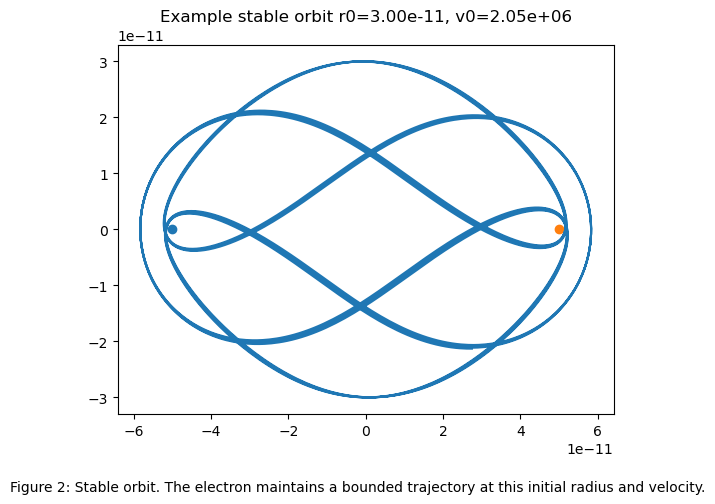

In [39]:
stable_idxs = np.argwhere(stability_matrix == 1)
unstable_idxs = np.argwhere(stability_matrix == 0) 

i, j = stable_idxs[0]
sol, stable, reason, E0 = run_orbit_energy_based(r0_vals[i], v0_vals[j])
x, y = sol.y[0], sol.y[1]
plt.figure(); plt.plot(x, y); plt.scatter(*proton1); plt.scatter(*proton2)
plt.title(f"Example stable orbit r0={r0_vals[i]:.2e}, v0={v0_vals[j]:.2e}")
plt.figtext(0.5, -0.05, "Figure 2: Stable orbit. The electron maintains a bounded trajectory at this initial radius and velocity.", ha='center')

plt.show()

***Figure 2***: *At this initial radius and tangential velocity, the attractive Coulomb force and centripetal motion balance sufficiently to maintain a bounded orbit. The electron remains at a roughly constant distance from the proton pair and traces a repeating, non-collapsing orbit.*

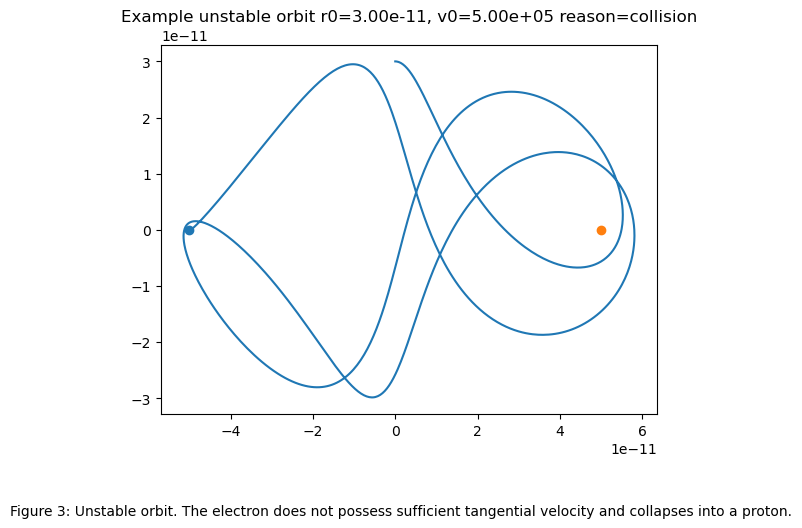

In [38]:
i, j = unstable_idxs[0]
sol, stable, reason, E0 = run_orbit_energy_based(r0_vals[i], v0_vals[j])
x, y = sol.y[0], sol.y[1]
plt.figure(); plt.plot(x, y); plt.scatter(*proton1); plt.scatter(*proton2)
plt.title(f"Example unstable orbit r0={r0_vals[i]:.2e}, v0={v0_vals[j]:.2e} reason={reason}")
plt.figtext(0.5, -0.10, "Figure 3: Unstable orbit. The electron does not possess sufficient tangential velocity and collapses into a proton.", ha='center')

plt.show()

***Figure 3***: *With a significantly lower initial velocity, the electron does not have enough centripetal kinetic energy to counteract the Coulomb attraction. As a result, its trajectory rapidly collapses inward, leading to a collision with one of the protons.*

## Acknowledgements
_(This section is where you acknowledge any help or support that you received in completing your project. It must include a statement regarding if and how Generative AI or other help was used in completing your project.)_

I received debugging assistance from ChatGPT during the development of this project. Specifically, I used ChatGPT to help identify a way to store stability outcomes in a matrix for generating the stability heatmap, and to troubleshoot parts of the code where indexing and array updates were producing errors. 

All simulation logic, parameter selection, analysis, figures, and written interpretation are my own work.

## References
*(Each reference in this section should include a citation associated with that reference in the body of your project. You may find it helpful to look at a typical Wikipedia page as an example of how to do this. Make sure you include references for source of datas, literature cited, and any python packages used beyond our standard ones. Additionally, you must also cite the sources for any code that you found on the internet or from peers.)*

[1] Stack Overflow. Adding caption below X-axis for a scatter plot using matplotlib” 
Available at: https://stackoverflow.com/questions/34010205/adding-caption-below-x-axis-for-a-scatter-plot-using-matplotlib (accessed Nov. 2025).

[2] SciPy Developers. “solve_ivp — SciPy v1.10.0 Manual.” 
Available at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html 
(accessed Nov. 2025).

[3] GeeksForGeeks: "numpy.hypot() in Python"
Available at: https://www.geeksforgeeks.org/python/numpy-hypot-python/(accessed Nov. 2025).


## Appendix 1: Code validation

### A1.1: Checking that the orbit shape looks reasonable

A simple check to make sure the simulation behaves correctly is to plot the electron’s trajectory for known “stable” initial conditions (e.g., r₀ = 3×10⁻¹¹ m, v₀ = 2.05×10⁶ m/s). The orbit should form a roughly closed, repeating path around the protons. As expected, the graph shows a smooth, bounded orbit without sudden jumps or spirals, confirming that the motion is being integrated correctly.


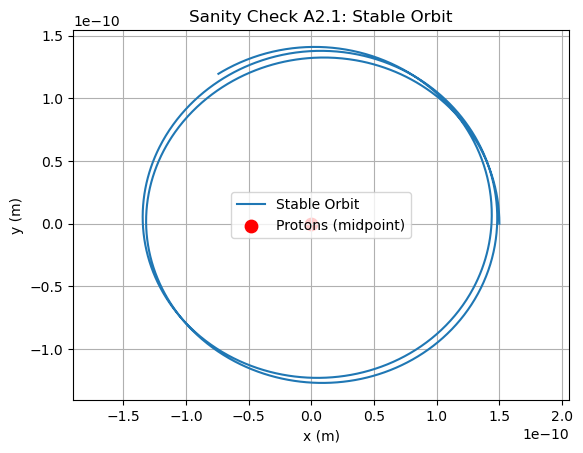

In [49]:
# Sanity check 1: stable orbit visualization
r0_stable = 1.5e-10
v0_stable = 2e6

state0 = (r0_stable, 0, 0, v0_stable)
t_span = (0, 10*T_guess)
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-9, atol=1e-9, max_step=T_guess/200)

x_s = sol.y[0]
y_s = sol.y[1]

plt.figure()
plt.plot(x_s, y_s, label="Stable Orbit")
plt.scatter(0, 0, color='red', s=80, label="Protons (midpoint)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Sanity Check A2.1: Stable Orbit")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


### A1.2: Confirming energy conservation

Another check is to verify that total mechanical energy remains roughly constant for a stable orbit. Using the same stable orbit parameters, I plotted kinetic, potential, and total energy over time. The total energy fluctuates minimally, which is consistent with a correctly functioning integrator and physically realistic motion.


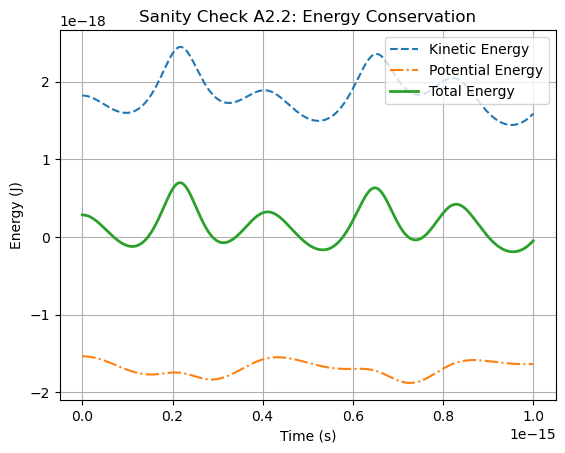

In [56]:
# Sanity check 2: energy conservation
vx_s = sol.y[2]
vy_s = sol.y[3]
v2 = vx_s**2 + vy_s**2

r_vals = np.sqrt(x_s**2 + y_s**2)
KE = 0.5 * m_e * v2
PE = -k_e * e**2 / r_vals
E_total = KE + PE

plt.figure()
plt.plot(sol.t, KE, '--', label="Kinetic Energy")
plt.plot(sol.t, PE, '-.', label="Potential Energy")
plt.plot(sol.t, E_total, label="Total Energy", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Sanity Check A2.2: Energy Conservation")
plt.grid(True)
plt.legend()
plt.show()


### A1.3: 

For this sanity check, I looked at the stability heatmap to pick an example of an unstable orbit, then ran a simulation for that initial condition. By plotting both the electron’s trajectory and its energy over time, I could see whether the behavior matched what I expected from the heatmap. As predicted, the electron quickly collapsed toward a proton, and the energy plot showed a sharp change consistent with a collision. Everything matched the prediction perfectly—yay!

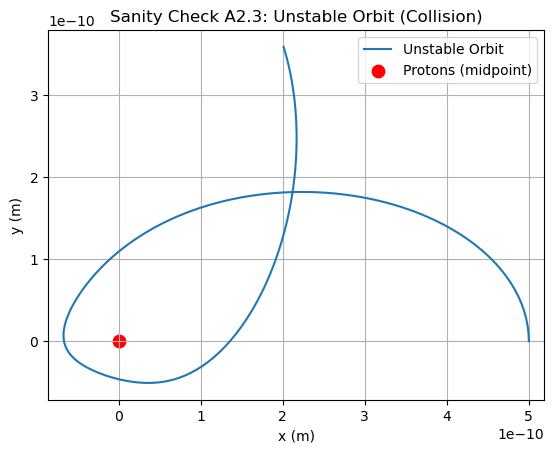

In [53]:
# Sanity check 3: unstable orbit visualization (collision)
r0_unstable = 5e-10
v0_unstable = 5e5

state0 = (r0_unstable, 0, 0, v0_unstable)
t_span = (0, 10*T_guess)
sol_u = solve_ivp(diff_eqns, t_span, state0, rtol=1e-9, atol=1e-9, max_step=T_guess/200)

x_u = sol_u.y[0]
y_u = sol_u.y[1]

plt.figure()
plt.plot(x_u, y_u, label="Unstable Orbit")
plt.scatter(0, 0, color='red', s=80, label="Protons (midpoint)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Sanity Check A2.3: Unstable Orbit (Collision)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


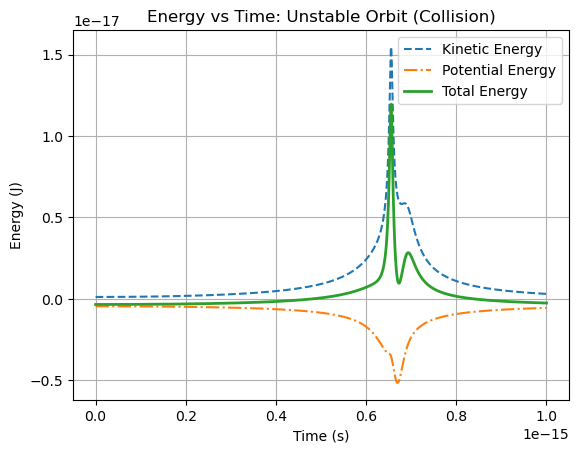

In [54]:
# Energy calculation for the unstable orbit
vx_u = sol_u.y[2]
vy_u = sol_u.y[3]
v2_u = vx_u**2 + vy_u**2

r_vals_u = np.sqrt(x_u**2 + y_u**2)
KE_u = 0.5 * m_e * v2_u
PE_u = -k_e * e**2 / r_vals_u
E_total_u = KE_u + PE_u

plt.figure()
plt.plot(sol_u.t, KE_u, '--', label="Kinetic Energy")
plt.plot(sol_u.t, PE_u, '-.', label="Potential Energy")
plt.plot(sol_u.t, E_total_u, label="Total Energy", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Energy vs Time: Unstable Orbit (Collision)")
plt.grid(True)
plt.legend()
plt.show()


## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

In this project, I got to extend how I use vectors and matrices, especially for storing results and looping through them efficiently. I also learned some new tricks, like using `np.hypot` for distances and setting up events in `solve_ivp` to detect things like collisions or escapes. One of the bigger challenges was figuring out a good way to check if an orbit was stable—I was originally just looking at the electron’s distance from the center at the end, but switching to an energy-based approach worked much better. I also ran into a few small debugging hiccups along the way, but nothing I couldn’t figure out.

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

One part of my code that I think worked really well was the function that calculates the orbit and classifies it based on why it ended—whether it was stable, collided, or escaped. It made running simulations and generating the heatmap really straightforward. 

Another part was working in small chuncks and having small functions so its easy to read through rather than having one large peice of code.


### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

In this project, I focused on translating the classical Coulomb interactions into a working simulation and exploring how different initial conditions affected orbital stability. I chose a phase space that varied the electron’s initial distance and velocity, and I systematically ran simulations across this space to identify stable and unstable regions. While I didn’t learn any new physics, I gained a much better understanding of how to turn physical laws into code.


### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

I think I did well in setting up the simulation so that energy could be used to reliably determine stability, which made the investigation more efficient. One area for improvement would be exploring a wider range of initial conditions or more complex multi-electron setups to see how stability changes in less symmetric cases.

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

I think the heatmap and example orbit plots worked really well to show stability and give a clear visual of the system’s behavior. To improve further, I could add additional plots like **energy vs. time for stable and unstable orbits**, or **phase-space trajectories** showing velocity vs. position, which would give more insight into why some orbits are stable and others aren’t.
